<a href="https://colab.research.google.com/github/marcusvbastos/digitalinnovationone/blob/main/Projeto_Marcus_Vinicius_Bastos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Categorias encontradas: ['Loide.jpg', 'Debi', 'Debi.jpg', 'Loide']
Total de imagens: 202
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 115s 23s/step - accuracy: 0.5318 - loss: 14.4233 - val_accuracy: 0.8333 - val_loss: 5.8844
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 111s 23s/step - accuracy: 0.8945 - loss: 5.6288 - val_accuracy: 0.8667 - val_loss: 9.5689
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 111s 23s/step - accuracy: 0.9758 - loss: 0.8507 - val_accuracy: 0.8667 - val_loss: 11.7411
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 141s 22s/step - accuracy: 0.9780 - loss: 0.7958 - val_accuracy: 0.8667 - val_loss: 12.1418
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 142s 22s/step - accuracy: 0.9697 - loss: 0.3539 - val_accuracy: 0.8667 - val_loss: 11.8338


1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.9032 - loss: 9.8584
Test Loss: 9.858447074890137
Test Accuracy: 0.9032257795333862


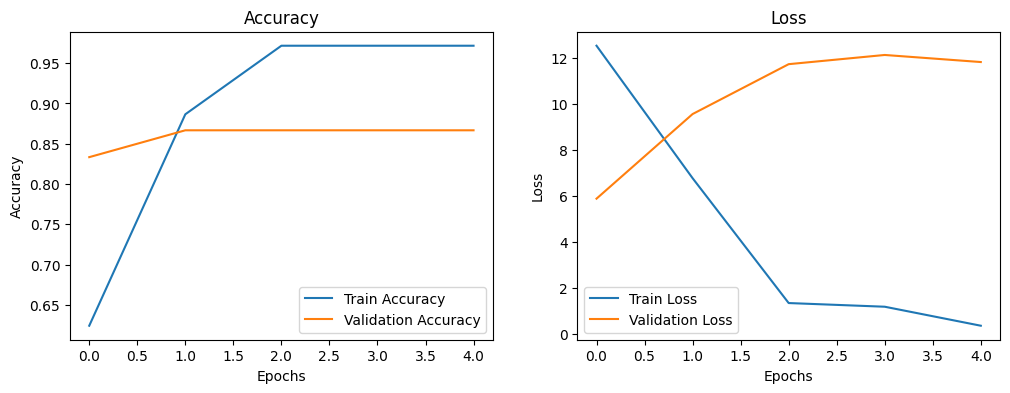

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
import tensorflow as tf

# Função para carregar imagens e redimensioná-las para 224x224
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    return x

# Caminho raiz das imagens
root = '/content/Debi_Loide'
# Diretório para salvar o modelo
model_save_path = '/content/modelo_debi_loide.h5'
train_split, val_split = 0.7, 0.15

# Verificando se o diretório raiz existe
if not os.path.exists(root):
    raise ValueError(f"O diretório {root} não existe. Verifique o caminho.")

# Obtendo imagens e suas categorias
data = []
categories = set()
for filename in os.listdir(root):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
        category = filename.split('(')[0].strip()
        categories.add(category)
        img_path = os.path.join(root, filename)
        try:
            x = get_image(img_path)
            data.append({'x': x, 'y': category})
        except Exception as e:
            print(f"Erro ao carregar a imagem {img_path}: {str(e)}")

categories = list(categories)
print(f"Categorias encontradas: {categories}")
print(f"Total de imagens: {len(data)}")

if len(data) == 0:
    raise ValueError("Nenhuma imagem foi carregada. Verifique os tipos de arquivo.")

# Convertendo categorias para índices
category_to_index = {category: index for index, category in enumerate(categories)}
for item in data:
    item['y'] = category_to_index[item['y']]

# Dividindo os dados em treino, validação e teste
random.shuffle(data)
train_size = int(train_split * len(data))
val_size = int(val_split * len(data))

train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

# Separando as imagens e os rótulos
x_train = np.array([d['x'] for d in train_data])
y_train = np.array([d['y'] for d in train_data])
x_val = np.array([d['x'] for d in val_data])
y_val = np.array([d['y'] for d in val_data])
x_test = np.array([d['x'] for d in test_data])
y_test = np.array([d['y'] for d in test_data])

# Convertendo os rótulos para one-hot encoding
y_train = to_categorical(y_train, num_classes=len(categories))
y_val = to_categorical(y_val, num_classes=len(categories))
y_test = to_categorical(y_test, num_classes=len(categories))

# Criando o modelo
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg.layers:
    layer.trainable = False

model = Sequential([
    vgg,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

# Compilando o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Treinando o modelo
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=32)

# Salvando o modelo
model.save(model_save_path)

# Avaliando o modelo
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Plotando a acurácia e a perda
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
